In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np

376 408 3


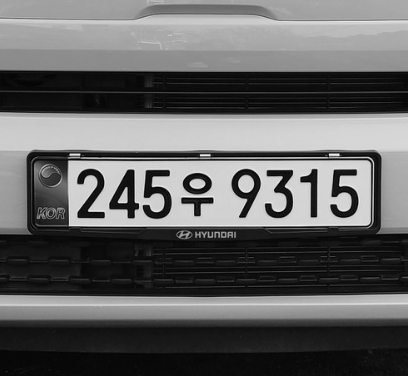

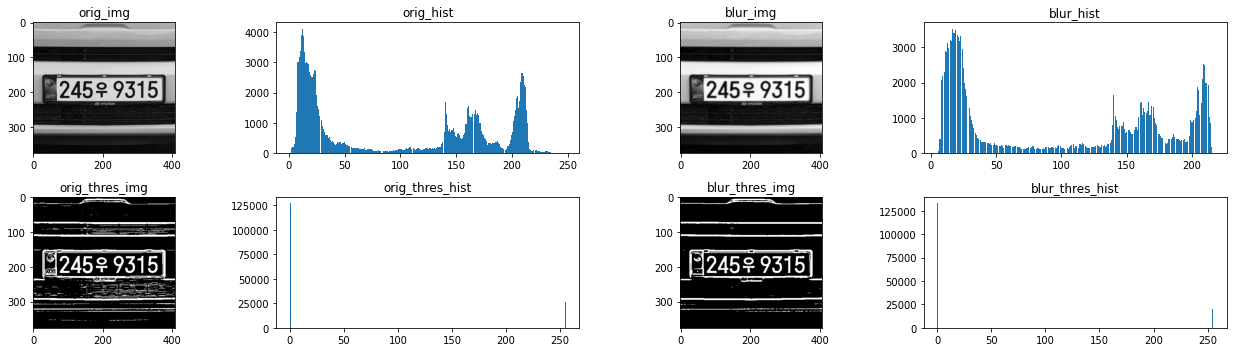

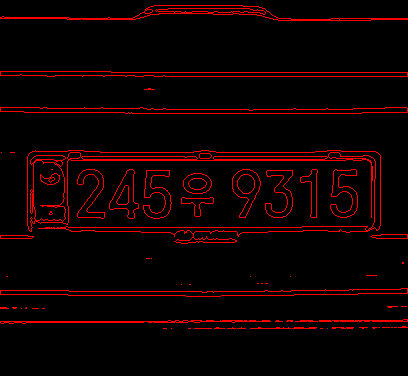

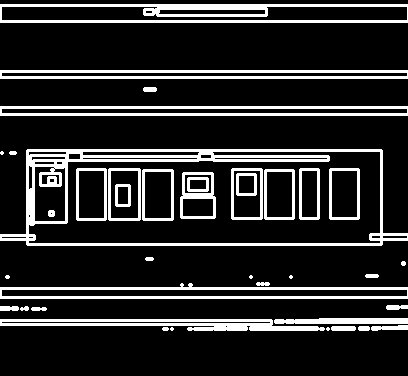

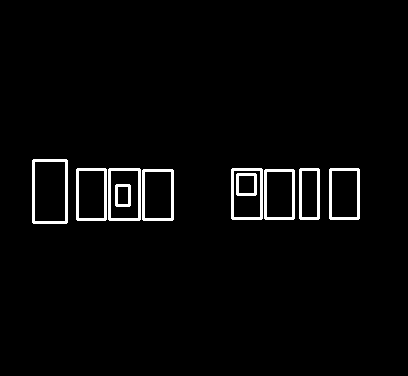

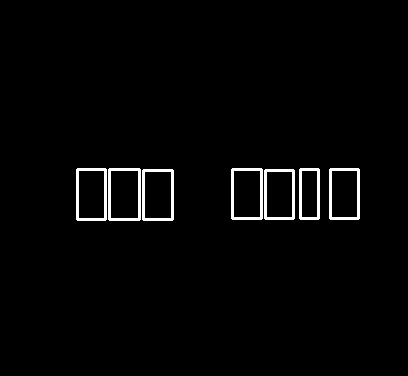

194.0
34 157 365 73
0.5564285714285714
0.5493333333333333
0.4897959183673469
0.5763546798029556
0.5372023809523809
0.5850340136054422
0.5043731778425656


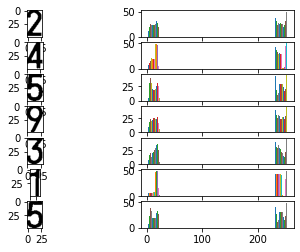

'\n번호판 Contours 가 없었을 때를 대비하여\n10번째 단계에서는 처음에 선별되지 못한 Contours에 대해서도 후보군을 추린다.\n로직은 위에서 했던 것과 동일하다.\n'

In [ ]:
def imshow(image, windowname='show'):
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


# Read Input Image
img_ori = cv2.imread('car(1).png')

# image size check
height, width, channel = img_ori.shape
print(height, width, channel)

# Convert Image to Grayscale
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)
imshow(gray)

# Adaptive Thresholding
"""
Thresholding을 해주기 전에 가우시안 블러를 해주는 것이 번호판을 더 잘 찾게 만들어 줄 수 있다.
가우시안 블러는 사진의 노이즈를 없애는 작업이다.
가우시안 블러를 적용해야하는 이유는 아래 4-1에서 설명한다.

그럼 먼저 Thresholding을 살펴보자.
Thresholding 이란 지정한 threshold 값을 기준으로 정하고
이보다 낮은 값은 0, 높은 값은 255로 변환한다. 즉 흑과 백으로만 사진을 구성하는 것이다.

이걸 해주는 이유는 5번째 단계에서 Contours를 찾으려면 검은색 배경에 흰색 바탕이어야 한다.
또 육안으로 보기에도 객체를 더 뚜렷하게 볼 수 있다.
"""

img_blurred = cv2.GaussianBlur(gray, ksize=(5, 5), sigmaX=0)
'''
적응 임계처리 
방법으로 평균이 있고, 가우시안이 있다
'''
img_blur_thresh = cv2.adaptiveThreshold(
    img_blurred,
    maxValue=255.0,  # 임계값 함수 최댓값. 보통 255
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # 블록 평균 계산 방법 지정.
    thresholdType=cv2.THRESH_BINARY_INV,  # 이진화 반전
    blockSize=19,  # 블록 크기. 3 이상의 홀수
    C=9  # 블록 내 평균값 또는 블록 내 가중 평균값에서 뺄 값. (x, y) 픽셀의 임계값으로 𝑇(𝑥, 𝑦) = 𝜇(𝑥, 𝑦 )− 𝐶 를 사용
)
## -> Gaussian Blur 비적용 / 적용 비교
"""
Thresholding 적용을 보았으니 가우시안 블러를 사용하는 이유를 알기위해
적용했을 때와 적용하지 않았을 때를 출력해본다.
"""
img_thresh = cv2.adaptiveThreshold(
    gray,
    maxValue=255.0,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY_INV,
    blockSize=19,
    C=9
)
plt.figure(figsize=(18, 5))
img_type = ['orig', 'blur', 'orig_thres', 'blur_thres']
img_type_array = [gray, img_blurred, img_thresh, img_blur_thresh]
for i in range(1, 9, 2):
    plt.subplot(2, 4, i)
    plt.title(f'{img_type[(i - 1) // 2]}_img')
    plt.imshow(img_type_array[(i - 1) // 2], 'gray')
    plt.subplot(2, 4, i + 1)
    # print((i-1)//2)
    plt.title(f'{img_type[(i - 1) // 2]}_hist')
    plt.hist(img_type_array[(i - 1) // 2].ravel(), 256)
plt.tight_layout()
plt.show()

# cv2.imshow('img_blurred', img_blurred)
# cv2.imshow("img_thresh", img_thresh)
# cv2.imshow("img_blur_thresh", img_blur_thresh)
# cv2.waitKey(0)

# 언뜻보기엔 큰 차이를 못느낄 수 있지만 번호판 밑부분을 보면 좀 더 검은색 부분이 많아졌다.

##  Find Contours
"""
Contours란 동일한 색 또는 동일한 강도를 가지고 있는 영역의 경계선을 연결한 선이다.

findContours()는 이런 Conturs들을 찾는 opencv 메소드이다.
위 메소드는 검은색 바탕에서 흰색 대상을 찾는다.
그래서 4번째 단계에서 Thresholding을 해주고 가우시안 블러를 적용해준 것이다.

그런데 공식문서에는 findCountours의 리턴 값으로
image, contours, hierachy 이렇게 3개가 나온다고 나와있지만
현재 첫번째 리턴 값인 image가 사라진 듯하다.
그래서 contours와 로 리턴을 받았다. hierachy는 쓸 일이 없어 로 받음

사진의 윤곽선을 모두 딴 후 opencv의 drawContours() 메소드로
원본사진이랑 크기가 같은 temp_result란 변수에 그려보았다
"""

contours, _ = cv2.findContours(
    img_blur_thresh,
    mode=cv2.RETR_LIST,  # 외곽선 검출 모드
    method=cv2.CHAIN_APPROX_SIMPLE  # 외곽선 근사화 방법.
)
# print(_)
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

# contourIdx: 외곽선 인덱스. 음수(-1)를 지정하면 모든 외곽선을 그린다.
# color: 외곽선 색상 • thickness: 외곽선 두께. thinkness < 0이면 내부를 채운다.
#
cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(0, 0, 255))
imshow(temp_result, 'temp_result')

# Prepare Data
"""
원본 사진과 동일한 크기에다가 찾은 Countours들의 좌표를 이용해
사각형 형태로 그려본다. 동시에 딕셔너리를 하나 만들어 contours들의 정보를 저장한다.
"""

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x + w, y + h), color=(255, 255, 255), thickness=2)

    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

cv2_imshow(temp_result)
cv2.waitKey(0)
cv2.destroyAllWindows()
# Select Candidates by Char Size
"""
이제 번호판 글자인 것 같은 Contours들을 추려내야한다.

많은 방법이 있겠지만 단순히 생각해서
번호판의 숫자들을 손글씨처럼 다 다르지 않고 일정한 비율을 가진다.

때문에 이 비율을 이용하면 대충은 번호판 같은 contours들을 추려낼 수 있다.
아래 코드에서는 최소 비율을 0.25와 최대 비율을 1.0으로 설정한 후
contours의 너비와 높이를 이용해 비율을 구하고
우리가 정한 기준에 맞는 contours들만 따로 저장하였다.
"""

MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']

    if area > MIN_AREA \
            and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
            and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x'] + d['w'], d['y'] + d['h']), color=(255, 255, 255),
                  thickness=2)

cv2_imshow(temp_result)
cv2.waitKey(0)
# cv2.destroyAllWindows()

"""
위 사진은 추려낸 contours들이다.
번호판 위치에 contours들이 선별된 걸 볼 수 있지만
전혀 관련 없는 영역의 contours들도 저장되었다.
이제 더 기준을 강화하여 번호판 글자들을 찾아야한다.
"""

## Select Candidates by Arrangement of Contours
"""
남은 contours 중에 확실하게 번호판을 찾기 위해 기준을 강화한다.
번호판의 특성을 고려했을 때 세울 수 있는 기준은 아래와 같다.

1. 번호판 Contours의 width와 height의 비율은 모두 동일하거나 비슷하다.
2. 번호판 Contours 사이의 간격은 일정하다.
3. 최소 3개 이상 Contours가 인접해 있어야한다. (대한민국 기준)
"""

MAX_DIAG_MULTIPLYER = 5
MAX_ANGLE_DIFF = 12.0
MAX_AREA_DIFF = 0.5
MAX_WIDTH_DIFF = 0.8
MAX_HEIGHT_DIFF = 0.2
MIN_N_MATCHED = 3

cnt_recursive = 0
def find_chars(contour_list):
    global cnt_recursive
    cnt_recursive += 1
    matched_result_idx = []

    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
                    and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
                    and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])
        matched_contours_idx.append(d1['idx'])

        # 최소 갯수를 만족할 때 까지 반복
        # 만약 끝까지 갔는데도 못찾으면 for문 완료
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        recursive_contour_list = find_chars(unmatched_contour)

        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx


result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x'] + d['w'], d['y'] + d['h']), color=(255, 255, 255),
                      thickness=2)

cv2_imshow(temp_result)
cv2.waitKey(0)

### Rotate plate image 
PLATE_WIDTH_PADDING = 1.3  # 1.3
PLATE_HEIGHT_PADDING = 1.5  # 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2

    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING

    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    print(sorted_chars[0]['cy'])
    triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
    triangle_hypotenus = np.linalg.norm(
        np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) -
        np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
    )

    angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

    rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)

    img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))

    img_cropped = cv2.getRectSubPix(
        img_rotated,
        patchSize=(int(plate_width), int(plate_height)),
        center=(int(plate_cx), int(plate_cy))
    )

    if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[
        0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
        continue

    plate_imgs.append(img_cropped)
    plate_infos.append({
        'x': int(plate_cx - plate_width / 2),
        'y': int(plate_cy - plate_height / 2),
        'w': int(plate_width),
        'h': int(plate_height)
    })
    x = int(plate_cx - plate_width / 2)
    y = int(plate_cy - plate_height / 2)
    w = int(plate_width)
    h = int(plate_height)
    print(x, y, w, h)
    num_idx = 1
    for sorted_char in sorted_chars:
        number_crop = cv2.getRectSubPix(
            img_rotated,
            patchSize=(int(sorted_char['w']), int(sorted_char['h'])),
            center=(int(sorted_char['cx']), int(sorted_char['cy']))
        )
        ret, number_crop = cv2.threshold(number_crop,127, 255,cv2.THRESH_BINARY_INV)
        # print(number_crop.flatten())
        print(len(np.where(number_crop.flatten() == 255)[0])/len(number_crop.flatten()))
        # print(len(np.where(number_crop.flatten()-127>0)[0]/len(number_crop.flatten())))
        plt.subplot(len(sorted_chars), 2, num_idx)
        num_idx += 1
        plt.imshow(number_crop, 'gray')
        plt.subplot(len(sorted_chars), 2, num_idx)
        plt.hist(number_crop)
        num_idx += 1
    plt.show()
    img_out = img_ori.copy()
    cv2.rectangle(img_out, pt1=(x, y), pt2=(x + w, y + h), color=(255, 0, 0), thickness=2)
    # cv2.imshow("test", img_cropped)
    # cv2.imshow("orig", img_out)
    # cv2.waitKey(0)


"""
번호판 Contours 가 없었을 때를 대비하여
10번째 단계에서는 처음에 선별되지 못한 Contours에 대해서도 후보군을 추린다.
로직은 위에서 했던 것과 동일하다.
"""
# longest_idx, longest_text = -1, 0
# plate_chars = []

# for i, plate_img in enumerate(plate_imgs):
#     plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
#     _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

#     # find contours again (same as above)
#     contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

#     plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
#     plate_max_x, plate_max_y = 0, 0

#     for contour in contours:
#         x, y, w, h = cv2.boundingRect(contour)

#         area = w * h
#         ratio = w / h

#         if area > MIN_AREA \
#         and w > MIN_WIDTH and h > MIN_HEIGHT \
#         and MIN_RATIO < ratio < MAX_RATIO:
#             if x < plate_min_x:
#                 plate_min_x = x
#             if y < plate_min_y:
#                 plate_min_y = y
#             if x + w > plate_max_x:
#                 plate_max_x = x + w
#             if y + h > plate_max_y:
#                 plate_max_y = y + h


#     img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
#     cv2.imshow("test", img_result)
#     cv2.waitKey(0)

# info = plate_infos[longest_idx]
# chars = plate_chars[longest_idx]

# print(chars)

# img_out = img_ori.copy()

# cv2.rectangle(img_out, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=2)
